In [1]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

from collections import Counter

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.models.phrases import Phrases
from textblob import TextBlob
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from scipy.sparse import save_npz, load_npz

In [2]:
#set seed so that code output is deterministic
random.seed(30)  # Set the seed for Python's random module
np.random.seed(30)  # Set the seed for NumPy's random module

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [4]:
data = data.drop(columns = ['index'])
print (data.shape)
data.head()

(99186, 7)


,text_type,ID,year,long_text,clean_text,word_count,tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]"
1,comment,gtfqkbv,2021,"That’s been there for several years, sent a pi...",years sent pic cuntry friend long time ago,8,"[year, send, pic, cuntry, friend, long, time, ..."
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]"


In [5]:
#include column with additional stopwords removal
#created the filtered corpus from another notebook and imported it here for use
# Read the file
with open('updated_corpus_new.txt', 'r') as f:
    updated_tokens = f.readlines()

# Remove newline characters
updated_tokens = [line.strip() for line in updated_tokens]


data['updated_tokens'] = updated_tokens

In [6]:

#convert list of strings to dataframe column with list of tokens on each row
data['updated_tokens'] = data['updated_tokens'].apply(lambda x: list(tokenize(x)))

In [7]:
#dataframe of all empty token lists due to removal of additional stopwords
empty_tokens = data[data['updated_tokens'].apply(lambda x: len(x) == 0)]

empty_tokens.shape

(3171, 8)

In [8]:
#adjust corpus to remvoe rows with empty token lists
row_id = empty_tokens['ID'] #id of rows with empty token list

updated_data = data[~data['ID'].isin(row_id)]
updated_data

,text_type,ID,year,long_text,clean_text,word_count,tokens,updated_tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]",[road]
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]","[single, travel, past]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]","[shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]","[hilarious, spring, souk]"
6,comment,gtfw6yj,2021,Eugene's first day as a signwriter for Country...,eugene s day signwriter country artificial pro...,8,"[eugene, s, day, signwriter, country, artifici...","[artificial, product]"
...,...,...,...,...,...,...,...,...
99181,submission,14f46ji,2023,"Best beauty saloons in Dubai? Hello fellas, I ...",best beauty saloons dubai hello fellas moved w...,35,"[good, beauty, saloon, dubai, hello, fellas, m...","[beauty, saloon, hello, wife, real, saloon, re..."
99182,submission,14f4uyi,2023,Found the r/dubai redditors who kept telling m...,found r dubai redditors kept telling know navi...,10,"[find, r, dubai, redditor, keep, tell, know, n...","[navigate, roundabout]"
99183,submission,14f4ri3,2023,Scam ? Healthy.line My sister has a CBD debit ...,scam healthy line sister cbd debit card month ...,47,"[scam, healthy, line, sister, cbd, debit, card...","[scam, healthy, line, sister, cbd, debit, card..."
99184,submission,14f4k3r,2023,Thoughts on Expo City properties? Anyone else ...,thoughts expo city properties checked expo cit...,21,"[thought, expo, city, property, check, expo, c...","[expo, property, expo, sale, page, pleasant, d..."


In [10]:
#save filtered corpus to data

#filename = 'Data/filtered_corpus.csv'

#def export_csv():
#    '''
#    export filtered data to CSV
#    '''
#    updated_data.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)
#
#export_csv()

## **Word2Vec Model** 

### FULL CORPUS -->After initial preprocessing

In [270]:
#convert df['tokens'] to list of strings for word2vec model
corpus = data['tokens'].tolist()#.apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

[['cuntry', 'road', 'hoem'],
 ['year', 'send', 'pic', 'cuntry', 'friend', 'long', 'time', 'ago'],
 ['single', 'travel', 'cuntry', 'past', 'year'],
 ['happen', 'shop', 'dragon', 'mart'],
 ['absolutely', 'hilarious', 'spring', 'souk']]

In [271]:
#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
full_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 100)
   
#build a vocabulary
full_corpus_model.build_vocab(corpus, progress_per = 1000)

In [272]:
full_corpus_model.corpus_count #number of sentences/documents

99186

In [273]:
#train the word2vec model

full_corpus_model.train(
                corpus,
                total_examples = full_corpus_model.corpus_count,
                epochs = full_corpus_model.epochs
)

full_corpus_model.save('pretrained_models/full_corpus_model.model') #save model locally

In [274]:
num_unique_words = len(full_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")


Number of unique words in the vocabulary: 21945


In [275]:
full_corpus_model.wv.most_similar ('lulu')

[('nesto', 0.9526462554931641),
 ('cafeteria', 0.944524347782135),
 ('hypermarket', 0.9433149695396423),
 ('vegetable', 0.9389459490776062),
 ('spinney', 0.9366098046302795),
 ('waitrose', 0.933556854724884),
 ('mcdonalds', 0.9310055375099182),
 ('viva', 0.9293677806854248),
 ('spinneys', 0.9293380379676819),
 ('souq', 0.9275371432304382)]

In [276]:
full_corpus_model.wv.most_similar('reddit')

[('sub', 0.8964521288871765),
 ('subreddit', 0.8800749182701111),
 ('mod', 0.8635022640228271),
 ('thread', 0.82708740234375),
 ('delete', 0.8173986673355103),
 ('moderator', 0.801443338394165),
 ('bash', 0.8013561964035034),
 ('discussion', 0.799430787563324),
 ('post', 0.7976388335227966),
 ('forum', 0.7918344736099243)]

In [277]:
full_corpus_model.wv.doesnt_match(['ejari', 'rera', 'dewa', 'drive'])

'drive'

## **Word2Vec Model** with custom stopwords removed from corpus

In [278]:
#convert ['tokens'] column to list of strings for word2vec model
filtered_corpus = updated_data['updated_tokens'].tolist()

filtered_corpus[:5]

[['road'],
 ['single', 'travel', 'past'],
 ['shop', 'dragon', 'mart'],
 ['hilarious', 'spring', 'souk'],
 ['artificial', 'product']]

In [279]:
#code from codebasics and semicolon, both on youtube

#instantiate word2vec model on filtered corpus
filtered_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 100)
   
#build a vocabulary
filtered_corpus_model.build_vocab(filtered_corpus, progress_per = 1000)



In [280]:
#number of sentences in vocabulary
filtered_corpus_model.corpus_count

96015

In [281]:
#train the word2vec model

filtered_corpus_model.train(
                filtered_corpus,
                total_examples = filtered_corpus_model.corpus_count,
                epochs = filtered_corpus_model.epochs
)

filtered_corpus_model.save('pretrained_models/filtered_corpus_model.model') #save model locally

In [282]:
num_unique_words = len(filtered_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 7878


In [283]:
filtered_corpus_model.wv.most_similar ('lulu')

[('waitrose', 0.9720600843429565),
 ('carrefour', 0.969598650932312),
 ('spinney', 0.9673463106155396),
 ('fruit', 0.965188205242157),
 ('hypermarket', 0.959431529045105),
 ('vegetable', 0.9592266082763672),
 ('souq', 0.9531868100166321),
 ('supermarket', 0.952685534954071),
 ('overpriced', 0.9517564177513123),
 ('nesto', 0.9474257230758667)]

In [284]:
filtered_corpus_model.wv.most_similar ('fish')

[('grill', 0.9768821001052856),
 ('spice', 0.9746105074882507),
 ('pickle', 0.9689387679100037),
 ('garlic', 0.9656305909156799),
 ('vegetable', 0.9649478793144226),
 ('sandwich', 0.9610117077827454),
 ('farm', 0.960748553276062),
 ('falafel', 0.9601993560791016),
 ('mutton', 0.960173487663269),
 ('salad', 0.9595544338226318)]

In [285]:
filtered_corpus_model.wv.most_similar ('bridge')

[('szr', 0.9642577171325684),
 ('pavement', 0.9623650312423706),
 ('jam', 0.9579125642776489),
 ('khail', 0.9558984041213989),
 ('intersection', 0.9543856978416443),
 ('gate', 0.952586829662323),
 ('tunnel', 0.9524264335632324),
 ('sidewalk', 0.952196478843689),
 ('cycling', 0.9507838487625122),
 ('rush', 0.9499329328536987)]

In [286]:
filtered_corpus_model.wv.most_similar('reddit')

KeyError: "Key 'reddit' not present in vocabulary"

## **Word2Vec with bigrams**

In [287]:
#first model on full corpus

#code from gensim documentation

#train bigram detector
bigram_transform = Phrases (corpus, min_count = 1) #default threshold is 10.0, fewer phrases will be created

In [288]:
#check performance of bigram transform model
new_sentence = corpus[330]
print(bigram_transform[new_sentence])

['anymore', 'new', 'labor_law', 'common', 'blatant', 'good', 'company', 'care', 'sale', 'promotional', 'bdm', 'post', 'hire', 'look', 'filter', 'photo_cv', 'rife', 'real_estate', 'industry', 'say', 'uae', 'young', 'country', 'learn', 'motivation', 'law', 'change', 'align', 'progressive', 'practice', 'ahead', 'way', 'nature', 'place', 'live']


In [289]:
#create corpus with bigrams
bigram_full_corpus = [bigram_transform[sentence] for sentence in corpus]

#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
bigram_full_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 100)
   
#build a vocabulary
bigram_full_corpus_model.build_vocab(bigram_full_corpus, progress_per = 1000)

In [290]:
bigram_full_corpus_model.corpus_count

99186

In [291]:
#train the word2vec model

bigram_full_corpus_model.train(
                bigram_full_corpus,
                total_examples = bigram_full_corpus_model.corpus_count,
                epochs = bigram_full_corpus_model.epochs
)

bigram_full_corpus_model.save('pretrained_models/bigram_full_corpus_model.model') #save model locally

In [292]:
num_unique_words = len(bigram_full_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 52736


In [293]:
bigram_full_corpus_model.wv.most_similar('lulu')

[('salad', 0.9917809367179871),
 ('avocado', 0.9917731881141663),
 ('chip', 0.9912051558494568),
 ('bread', 0.9904637336730957),
 ('menu', 0.989629864692688),
 ('juice', 0.9893547892570496),
 ('pickl', 0.9892104864120483),
 ('carton', 0.9889456033706665),
 ('powder', 0.9888132810592651),
 ('packet', 0.9884225130081177)]

In [294]:
bigram_full_corpus_model.wv.most_similar('real_estate')

[('market', 0.9539564251899719),
 ('oversupply', 0.9455468654632568),
 ('property', 0.9447397589683533),
 ('investment', 0.9445777535438538),
 ('lucrative', 0.9372889995574951),
 ('personal_loan', 0.929117739200592),
 ('invest', 0.9286069273948669),
 ('sponsorship', 0.9280118942260742),
 ('agency', 0.9271519184112549),
 ('mnc', 0.9266513586044312)]

In [295]:
bigram_full_corpus_model.wv.most_similar('reddit')

[('sub', 0.9664925932884216),
 ('mod', 0.9634584784507751),
 ('r_dubai', 0.962688148021698),
 ('subreddit', 0.9493028521537781),
 ('recent_post', 0.9480857253074646),
 ('mod_remove', 0.9408067464828491),
 ('thread', 0.9399752616882324),
 ('read', 0.9286966323852539),
 ('got_remove', 0.9271013140678406),
 ('post', 0.9222640991210938)]

In [296]:
#second model on filtered corpus 
#create corpus with bigrams
bigram_filtered_corpus = [bigram_transform[sentence] for sentence in filtered_corpus]

#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
bigram_filtered_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 100)
   
#build a vocabulary
bigram_filtered_corpus_model.build_vocab(bigram_filtered_corpus, progress_per = 1000)


In [297]:
bigram_filtered_corpus_model.corpus_count

96015

In [298]:
#train the word2vec model

bigram_filtered_corpus_model.train(
                bigram_filtered_corpus,
                total_examples = bigram_filtered_corpus_model.corpus_count,
                epochs = bigram_filtered_corpus_model.epochs
)

bigram_filtered_corpus_model.save('pretrained_models/bigram_filtered_corpus_model.model') #save model locally

In [299]:
num_unique_words = len(bigram_filtered_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 30615


In [300]:
bigram_filtered_corpus_model.wv.most_similar('real_estate')

[('market', 0.9834105372428894),
 ('property', 0.9786896109580994),
 ('agent', 0.9779227375984192),
 ('sale', 0.9772022366523743),
 ('value', 0.9754621386528015),
 ('invest', 0.9717615842819214),
 ('investment', 0.9623180031776428),
 ('cancel_ejari', 0.9589475393295288),
 ('low_interest', 0.9556249976158142),
 ('agency', 0.9554840922355652)]

In [301]:
bigram_filtered_corpus_model.wv.most_similar('reddit')

KeyError: "Key 'reddit' not present in vocabulary"

### **WORD CLUSTERING WITH WORD2VEC MODEL**

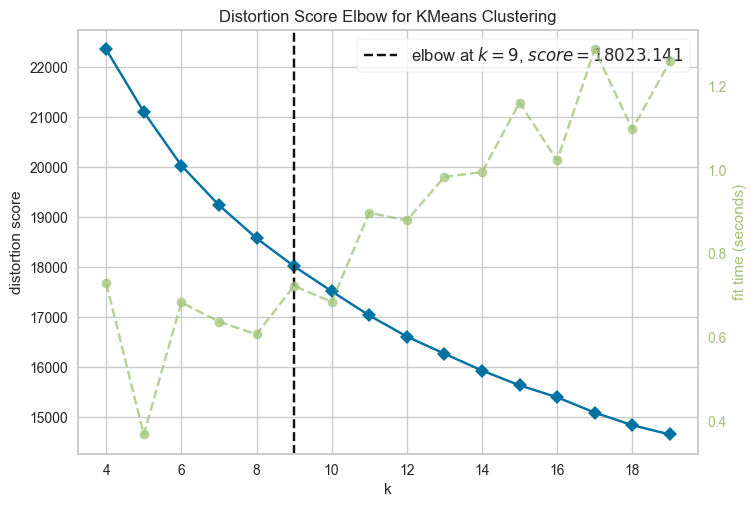

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [341]:
filtered_corpus_word_vectors = filtered_corpus_model.wv.vectors #2d word vectors for clustering

#determine optimum k-clusters using yellowbrick visualizer


kmeans = KMeans(init = 'k-means++', n_init = 10, random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (4,20))

visualizer.fit(filtered_corpus_word_vectors)
visualizer.show()



In [342]:
num_clusters = 9

# Kmeans clustering
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=0)
kmeans.fit(filtered_corpus_word_vectors)

# cluster label for each word
word_clusters = kmeans.labels_

# map word to cluster label
word_to_cluster = {word: cluster for word, cluster in zip(filtered_corpus_model.wv.index_to_key, word_clusters)}

# print 10 words in each cluster
for i in range(num_clusters):
    words_in_cluster = [word for word, cluster in word_to_cluster.items() if cluster == i]
    print(f"Cluster {i}: {words_in_cluster[:10]}")

Cluster 0: ['visit', 'couple', 'movie', 'notice', 'play', 'wife', 'stand', 'imagine', 'avoid', 'early']
Cluster 1: ['buy', 'food', 'water', 'area', 'restaurant', 'cheap', 'mall', 'small', 'building', 'house']
Cluster 2: ['real', 'deal', 'meet', 'travel', 'course', 'community', 'date', 'single', 'assume', 'emirate']
Cluster 3: ['drive', 'fine', 'stop', 'police', 'lane', 'road', 'driver', 'test', 'walk', 'fast']
Cluster 4: ['call', 'service', 'card', 'order', 'sell', 'bank', 'delivery', 'tip', 'charge', 'plan']
Cluster 5: ['eva', 'desk', 'instantly', 'bug', 'shocking', 'mechanic', 'daddy', 'newly', 'peep', 'ble']
Cluster 6: ['take', 'case', 'read', 'law', 'report', 'safe', 'rule', 'covid', 'public', 'parent']
Cluster 7: ['experience', 'price', 'business', 'visa', 'salary', 'cost', 'offer', 'low', 'government', 'market']
Cluster 8: ['family', 'local', 'school', 'learn', 'indian', 'culture', 'india', 'passport', 'middle', 'expat']
